In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib, random
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Thu Feb  5 11:04:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 31%   56C    P8             31W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

#config['dataset']['examples']['subjects'] = 'one_subject.csv'
#config['dataset']['examples']['subjects'] = 'two_subjects.csv'
config['dataset']['examples']['subjects'] = 'ten_subjects.csv'
#config['dataset']['examples']['subjects'] = '100_subjects.csv'
#config['dataset']['examples']['subjects'] = '2026-01-26_preprocessed.csv'

config['dataset']

Loading 2026-02-02_config.yaml


{'name': 'ShapeNet',
 'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'subjects': 'ten_subjects.csv', 'variant': '2026-01-15'},
 'metadata': {'parse_metadata': True,
  'unit_policy': 'prefer_metadata',
  'default_unit': 0.01},
 'selectors': {'material_mask': 'uniform-seed'}}

In [7]:
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [8]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


10

In [9]:
train_config = config['training'].copy()
project.core.utils.pprint(train_config, 2, 100)

dict(len=9)
├── 'task':            dict(len=3)
|   ├── 'inputs':  list(len=1)
|   ├── 'targets': list(len=2)
|   └── 'losses':  dict(len=2)
├── 'split':           dict(len=4)
|   ├── 'key':        'category'
|   ├── 'test_ratio': 0.2
|   ├── 'val_ratio':  0.1
|   └── 'seed':       0
├── 'transform':       dict(len=4)
|   ├── 'normalize':  True
|   ├── 'image_mean': 1.0
|   ├── 'image_std':  1.0
|   └── 'apply_mask': True
├── 'loader':          dict(len=6)
|   ├── 'batch_size':         1
|   ├── 'shuffle':            True
|   ├── 'num_workers':        2
|   ├── 'persistent_workers': True
|   ├── 'prefetch_factor':    2
|   └── 'pin_memory':         True
├── 'model':           dict(len=2)
|   ├── 'backbone': dict(len=11)
|   └── 'heads':    dict(len=1)
├── 'physics_adapter': dict(len=5)
|   ├── 'nu_value':      0.4
|   ├── 'rho_bias':      1000
|   ├── 'rho_known':     True
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=2)
|   ├── '_class':        '

In [10]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)

len(train_ex), len(test_ex), len(val_ex)

Splitting examples
Test categories: {'ChestOfDrawers', 'Cabinet', 'Computer', 'CurioCabinet'}
Test subjects:   {'wss.1029fd5d71a06ea32ea98d69e91ba870', 'wss.18efc77e6837f7d311e76965808086c8'}
Train subjects: {'wss.107637b6bdf8129d4904d89e9169817b', 'wss.101354f9d8dede686f7b08d9de913afe', 'wss.1644df5fbb3b926029e82c550aa06a9d', 'wss.102a6b7809f4e51813842bc8ef6fe18', 'wss.100f39dce7690f59efb94709f30ce0d2', 'wss.18f4a9ed04407da57bd55ed4ce08f048', 'wss.133c16fc6ca7d77676bb31db0358e9c6'}
Val subjects:   {'wss.13b48456dad49f8762edbb9e1af21a03'}


(7, 2, 1)

In [11]:
%autoreload
import project.datasets.torch

transform_kws = train_config['transform']
use_cache = len(examples) < 100

train_set = project.datasets.torch.TorchDataset(train_ex, use_cache=use_cache, **transform_kws)
test_set = project.datasets.torch.TorchDataset(test_ex, use_cache=use_cache,  **transform_kws)
val_set = project.datasets.torch.TorchDataset(val_ex, use_cache=use_cache, **transform_kws)

In [12]:
loader_kws = train_config['loader'].copy()
loader_kws['shuffle'] = True
loader_kws['batch_size']  = 1
loader_kws['num_workers'] = 0
del loader_kws['persistent_workers'], loader_kws['prefetch_factor']

collate_fn = project.datasets.torch.collate_fn
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)

if test_set:
    test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
else:
    test_loader = None

if val_set:
    val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)
else:
    val_loader = None


In [13]:
import project.training

task_kws = train_config['task'].copy()

task_kws['inputs']  = ['image']
task_kws['targets'] = ['material']
task_kws['losses']  = {'material': 'CE'}

#task_kws['inputs']  = ['material']
#task_kws['targets'] = ['logE']
#task_kws['losses']  = {'logE': 'MSE'}

task = project.training.TaskSpec(**task_kws)
task_kws

Inputs:  ['image']
Targets: ['material']
Losses:  {'material': 'CE'}


{'inputs': ['image'], 'targets': ['material'], 'losses': {'material': 'CE'}}

In [14]:
%autoreload
import project.models
import copy

model_kws = copy.deepcopy(train_config['model'])

if True:
    backbone_kws = model_kws['backbone']
    backbone_kws['_class']        = 'UNet3Dv2'
    backbone_kws['out_channels']  = 16
    backbone_kws['conv_channels'] = 16
    backbone_kws['n_conv_units']  = 2
    backbone_kws['n_sub_levels']  = 2
    backbone_kws['kernel_size']   = 3
    backbone_kws['relu_leak']     = 0.1
    backbone_kws['norm_type']     = 'group'
    backbone_kws['num_groups']    = 4
    backbone_kws['upsample_mode'] = 'trilinear'

project.core.utils.pprint(model_kws)

model = project.models.build_model(task, model_kws)
model

dict(len=2)
├── 'backbone': dict(len=11)
|   ├── '_class':        'UNet3Dv2'
|   ├── 'out_channels':  16
|   ├── 'conv_channels': 16
|   ├── 'n_conv_units':  2
|   ├── 'n_sub_levels':  2
|   ├── 'kernel_size':   3
|   ├── 'relu_leak':     0.1
|   ├── 'norm_type':     'group'
|   ├── 'num_groups':    4
|   ├── 'pooling_type':  'max'
|   └── <1 more items>
└── 'heads':    dict(len=1)
    └── 'elasticity': dict(len=4)


MultiTaskModel(
  (backbone): UNet3Dv2(
    (enc): ConvBlock3D(
      (unit0): ConvUnit3D(
        (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (unit1): ConvUnit3D(
        (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (down): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sub): UNet3Dv2(
      (enc): ConvBlock3D(
        (unit0): ConvUnit3D(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slo

In [15]:
project.models.count_params(model)

backbone.enc.unit0.conv.weight                     432	(16, 1, 3, 3, 3)
backbone.enc.unit0.norm.weight                     16	(16,)
backbone.enc.unit0.norm.bias                       16	(16,)
backbone.enc.unit1.conv.weight                     6912	(16, 16, 3, 3, 3)
backbone.enc.unit1.norm.weight                     16	(16,)
backbone.enc.unit1.norm.bias                       16	(16,)
backbone.sub.enc.unit0.conv.weight                 13824	(32, 16, 3, 3, 3)
backbone.sub.enc.unit0.norm.weight                 32	(32,)
backbone.sub.enc.unit0.norm.bias                   32	(32,)
backbone.sub.enc.unit1.conv.weight                 27648	(32, 32, 3, 3, 3)
backbone.sub.enc.unit1.norm.weight                 32	(32,)
backbone.sub.enc.unit1.norm.bias                   32	(32,)
backbone.sub.sub.enc.unit0.conv.weight             55296	(64, 32, 3, 3, 3)
backbone.sub.sub.enc.unit0.norm.weight             64	(64,)
backbone.sub.sub.enc.unit0.norm.bias               64	(64,)
backbone.sub.sub.enc.unit1.co

471350

In [16]:
import project.physics

pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **train_config['physics_adapter']
)
physics_adapter

In [17]:
import torch.optim
optimizer_kws = train_config['optimizer'].copy()
optimizer_kws['lr'] = 1e-3
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

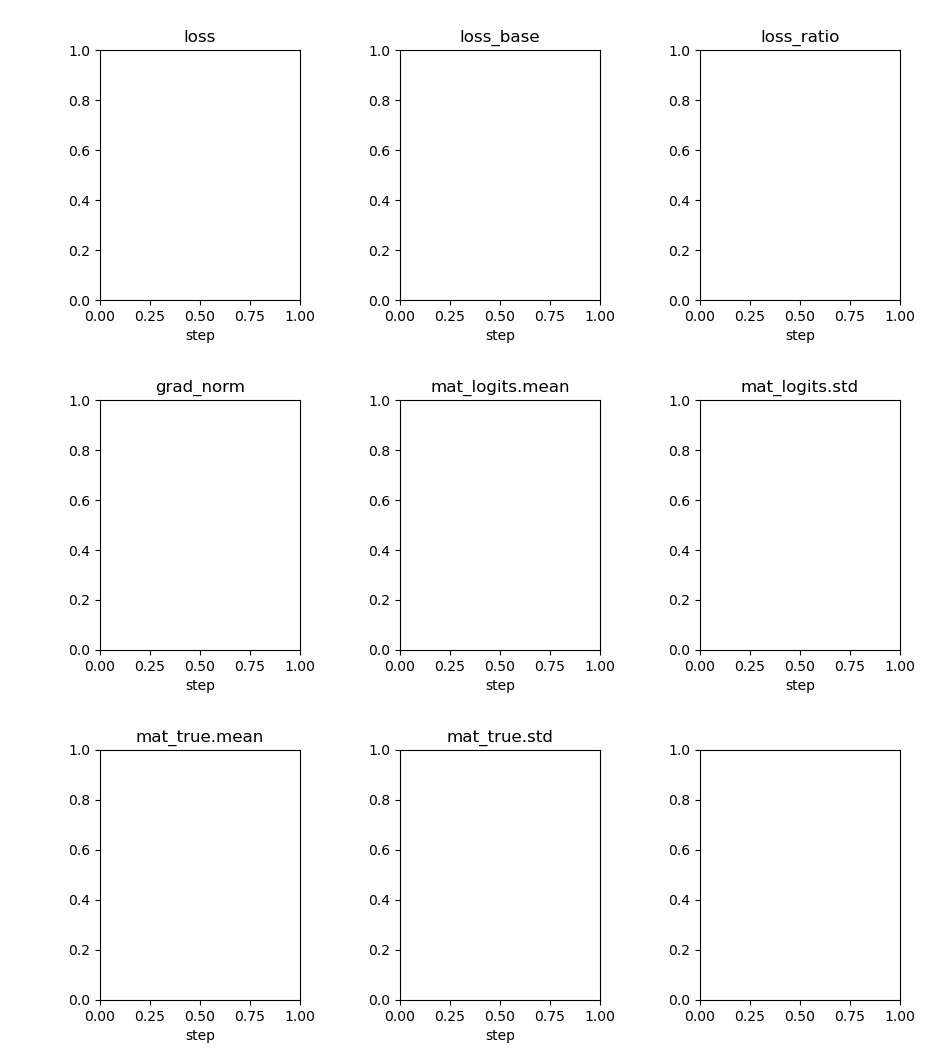

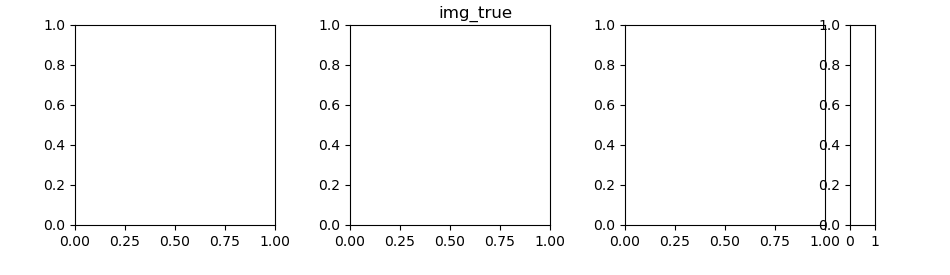

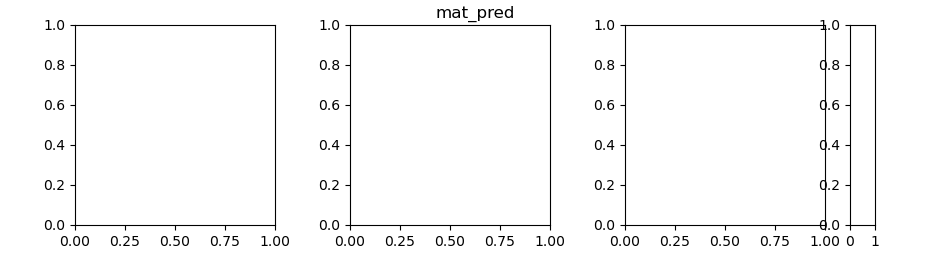

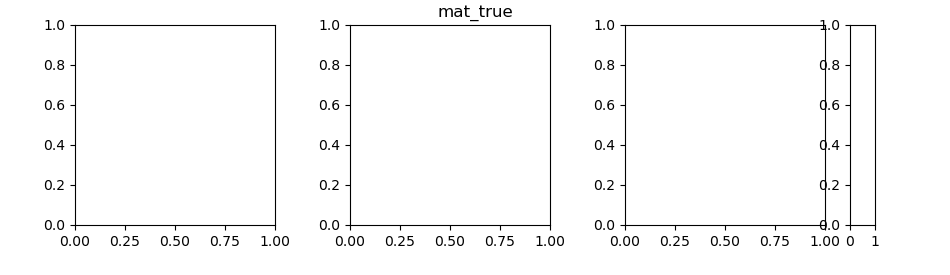

In [18]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

callbacks = [
    project.evaluation.LoggerCallback(task.metric_keys),
    project.evaluation.PlotterCallback(task.metric_keys),
    project.evaluation.ViewerCallback(task.viewer_keys),
    #project.evaluation.EvaluatorCallback(n_labels=task.material_labels),
    project.evaluation.TimerCallback(),
]

trainer = project.training.Trainer(
    task=task,
    model=model,
    optimizer=optimizer,
    physics_adapter=physics_adapter,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=callbacks
)

In [ ]:
%autoreload
#trainer.load_state(epoch=10)
trainer.train(num_epochs=100, val_every=1)

Start training
Start epoch 0
Saving checkpoints/checkpoint00000.pt
Start epoch 0 val phase
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/13b48456dad49f8762edbb9e1af21a03/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/13b48456dad49f8762edbb9e1af21a03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/13b48456dad49f8762edbb9e1af21a03/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/13b48456dad49f8762edbb9e1af21a03/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 0 | Val batch 0] start
load_data: {'t_delta': 2.5658, 'curr_alloc': 0.0018, 'curr_rsvd': 0.002, 'peak_alloc': 0.0018, 'peak_rsvd': 0.002}
forward:   {'t_delta': 0.8374, 'curr_alloc': 0.0018, 'curr_rsvd': 6.959, 'peak_alloc': 6.1995, 'pea

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:194: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


plotter: {'t_delta': 0.8869, 'curr_alloc': 0.0018, 'curr_rsvd': 6.959, 'peak_alloc': 0.0018, 'peak_rsvd': 6.959}


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:102: UserWarning: Adding colorbar to a different Figure <Figure size 950x275 with 4 Axes> than <Figure size 950x275 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(self.im_k, cax=self.cbar_ax)


viewer: {'t_delta': 1.1269, 'curr_alloc': 0.0018, 'curr_rsvd': 6.959, 'peak_alloc': 0.0018, 'peak_rsvd': 6.959}
timer: {'t_delta': 0.0008, 'curr_alloc': 0.0018, 'curr_rsvd': 6.959, 'peak_alloc': 0.0018, 'peak_rsvd': 6.959}
End epoch 0 val phase
Start epoch 0 train phase
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/133c16fc6ca7d77676bb31db0358e9c6/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/133c16fc6ca7d77676bb31db0358e9c6/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/133c16fc6ca7d77676bb31db0358e9c6/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/133c16fc6ca7d77676bb31db0358e9c6/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 0 | Train batch 0] start
load_data: {'t_delta': 2.2834, '